<a href="https://colab.research.google.com/github/Kevin2558/Data_Science_Borrador/blob/main/07_Deep_Learning/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Dataset**

In [25]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("divyansh22/dummy-astronomy-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/dummy-astronomy-data


## **Preprocesamiento de imágenes**

In [26]:
dataset_path = path + "/Cutout Files" # Ruta donde se encuentran las carpetas

# ImageDataGenerator facilitará el preprocesamiento de las imágenes
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Estandarizamos los valores de los pixeles y guardamos un 20% para el proceso
# de validación del modelo.
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Conjunto de entrenamiento.
train_generator = datagen.flow_from_directory(
    directory=dataset_path, # Ruta de las carpetas de las clases
    target_size=(64, 64), # Redimensionamineto de las imágenes a 64x64
    batch_size=32, # Creación de lotes de imágenes para eficiencia de memoria.
                   # Se procesan lotes de 32 imágenes a la vez. En el
                   # entrenamiento se actualizan los parámetros después de cada
                   # batch lo que ayuda a su estabilidad y rapidez
    class_mode='categorical', # Debido a que el dataset posee clases
    subset='training', # Así seleccionamos solo los datos de entrenamiento
    shuffle=True # Mezcla del orden de las imágenes. Si no lo hacemos las
                 # carpetas separan las dos clases y el modelo podria tener
                 # problemas de overfitting.
)

# Conjunto de validación.
val_generator = datagen.flow_from_directory(
    directory=dataset_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='validation' # Así seleccionamos solo los datos de validación
)

Found 3190 images belonging to 2 classes.
Found 796 images belonging to 2 classes.


## **Red Neural Convolucional**

Una red neuronal convolucional (CNN) se utiliza principalmente para problemas que requieran análisis de imágenes debido a que es capaz de:

* Detectar patrones espaciales (bordes, formas, texturas)
* Aprender jerarquías de características
* Reducir gradualmente la información hasta tomar una decisión (en este caso clasificación)

Veamos que es lo que hace cada capa y como se va desarrollando la red neuronal.

* **Capas convolucionales:**

  Una capa convolucional 2D aplica una serie de filtros (kernels) sobre la imágen para detectar patrones locales.

  Lo que hace es tomar una pequeña región de la imágen (en este caso 3x3) y multiplica sus valores por un filtro (matriz de pesos). Luego, este filtro se desliza ("convoluciona") por toda la imágen. Cada filtro genera un mapa de activación (feature map), que muestra dónde aparece ese patrón en la imágen.

  En esta capa se aprenden los borden horizontales, verticales, esquinas, líneas, colores, texturas, etc.

  Al aumentar el número de filtros se aprenderán características más abstractas. Cuantas más capas de convolución se coloquen, la imágen se observa más en profundidad.

* **Capa de max pooling:**

  Una capa de max pooling es una capa de submuestreo (downsampling) que reduce el tamaño de las imágenes, conservando solo la información más relevante.

  Lo que hace es tomar bloques (en este caso 2x2) y se queda con el valor máximo por bloque.

  Reduce la dimensión de la imagen a la mitad, lo que reduce el costo computacional y aumenta la invarianza espacial.

* **Capa de aplanado:**

  Una capa de aplanado convierte la salida a un vector de 1D para poder contectarla con las capas densas, las cuales esperan vectores como entrada.

* **Capa densa:**

  Una capa densa es una capa totalmente conectada, es decir, cada neurona se conecta con todas las salidas de la capa anterior.

  Aquí se aprenden combinaciones globales de todas las características que encontró la red.

  Esta capa actúa como un clasificador, es decir, interpreta las "evidencias" encontradas por las capas convolucionales y decide que clase es más probable.

* **Capa de salida:**

  En la capa de salida se construyen (en este caso) dos neuronas de decisión entre 'star' y 'galaxy'. Se entregará un vector el cual contiene la probabilidad de pertenecer a una o a otra clase, a través de la activación softmax.

Consideraciones para la elección de capas:

* Para extraer patrones visuales: Conv2 + ReLU
* Para reducir tamaño: MaxPooling2D
* Conectar todo: Flatten + Dense
* Clasificar: Dense final con softmax

Veamos como podemos modificar o mejorar la arquitectura de la red neuronal convolucional

* **Aumenta la profundidad del modelo:**

  Mientras más capas convolucionales agreguemos, más jerarquías de patrones puede aprender la red. Lo cual permite capturar patrones más complejos, lo cual es indispensable al momento de discernir entre imágenes.

* **Evitar overfittng:**

  Esto lo podemos lograr a través de Dropout el cual apaga aleatoriamente algunas neuronas durante el entrenamiento, obligando al modelo a no depender demasiado de ciertas conexiones. Así el modelo generalizará de mejor manera cuando se evaluen datos nuevos.

* **Normalizar activaciones y acelerar entrenamiento:**

  Este lo podemos lograr a través de BatchNormalization. Aplicarlo justo después de una capa convolucional o una capa densa se considera buena práctica.

# **Modelo inicial**

In [11]:
# TensorFlow, layers y models nos ayudarán en la construcción de las redes
# neuronales
import tensorflow as tf
from tensorflow.keras import layers, models

# Definimos un modelo secuencial, donde podemos ir definiendo capa tras capa de
# la red neuronal

model = models.Sequential([
    # 1ª capa convolucional
    layers.Conv2D(32, # Número de filtros (patrones) que aprenderá la red
                  (3, 3), # Tamaño de los filtros (región 3x3)
                  activation='relu', # Introduce no linealidad, para aprender
                                     # relaciones complejas.
                  input_shape=(64, 64, 3)), # Tamaño de la imágen entrante y RGB
    layers.MaxPooling2D((2, 2)), # Bloques de información relevante

    # 2ª capa convolucional
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Aplanar las activaciones (de 2D a 1D)
    layers.Flatten(),

    # Capa completamente conectada
    layers.Dense(128, activation='relu'),

    # Capa de salida: 2 clases → softmax
    layers.Dense(2, activation='softmax')
])

# Compilar el modelo: Preparación del modelo para el entrenamiento
model.compile(
    optimizer='adam', # Optimizador de pesos
    loss='categorical_crossentropy', # Función de pérdida para clasificación
    metrics=['accuracy'] # Métrica para evaluar el desempeño
)

# Resumen de la arquitectura
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,410 (6.20 MB)

 Trainable params: 1,625,410 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

# **Modelo más profundo**

In [27]:
model_2 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

model_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,354 (2.61 MB)

 Trainable params: 683,906 (2.61 MB)

 Non-trainable params: 448 (1.75 KB)

# **Entrenamiento de los modelos**

In [12]:
history = model.fit(
    train_generator, # Entrega los lotes de imágenes y etiquetas para el
                     # entrenamiento
    epochs=10, # Número de iteraciones
    validation_data=val_generator # Entrega los lotes para monitoreo de mejora o
                                  # sobreajuste
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.7322 - loss: 0.6067

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 195ms/step - accuracy: 0.7324 - loss: 0.6062 - val_accuracy: 0.7638 - val_loss: 0.5349
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 204ms/step - accuracy: 0.7762 - loss: 0.4920 - val_accuracy: 0.7676 - val_loss: 0.4178
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 190ms/step - accuracy: 0.8009 - loss: 0.4053 - val_accuracy: 0.8254 - val_loss: 0.3801
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.8262 - loss: 0.3727 - val_accuracy: 0.8518 - val_loss: 0.3319
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 191ms/step - accuracy: 0.8587 - loss: 0.3222 - val_accuracy: 0.8354 - val_loss: 0.3656
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 203ms/step - accuracy: 0.8784 - loss: 0.2880 - val_accuracy: 0.8618 - val_loss: 0.3374
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 189ms/step - accuracy: 0.9014 - loss: 0.2463 - val_accuracy: 0.8618 - val_loss: 0.3248
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - accuracy: 0.9088 - loss: 0.2299 - val

In [28]:
history2 = model_2.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.7210 - loss: 1.2837

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 409ms/step - accuracy: 0.7214 - loss: 1.2782 - val_accuracy: 0.2362 - val_loss: 12.4899
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 414ms/step - accuracy: 0.8152 - loss: 0.4058 - val_accuracy: 0.2362 - val_loss: 6.9542
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 85s 446ms/step - accuracy: 0.8645 - loss: 0.3082 - val_accuracy: 0.8279 - val_loss: 0.4963
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 434ms/step - accuracy: 0.8827 - loss: 0.2624 - val_accuracy: 0.8241 - val_loss: 0.4086
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 378ms/step - accuracy: 0.9084 - loss: 0.2264 - val_accuracy: 0.7915 - val_loss: 0.5726
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 354ms/step - accuracy: 0.9324 - loss: 0.1621 - val_accuracy: 0.6859 - val_loss: 0.6043
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 353ms/step - accuracy: 0.9385 - loss: 0.1541 - val_accuracy: 0.8631 - val_loss: 0.3641
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 382ms/step - accuracy: 0.9500 - loss: 0.1356 - va

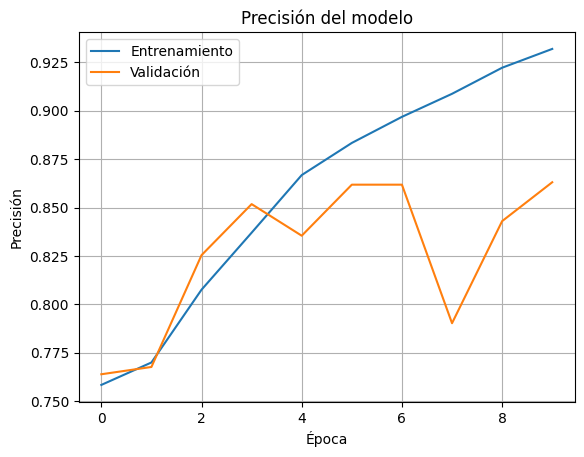

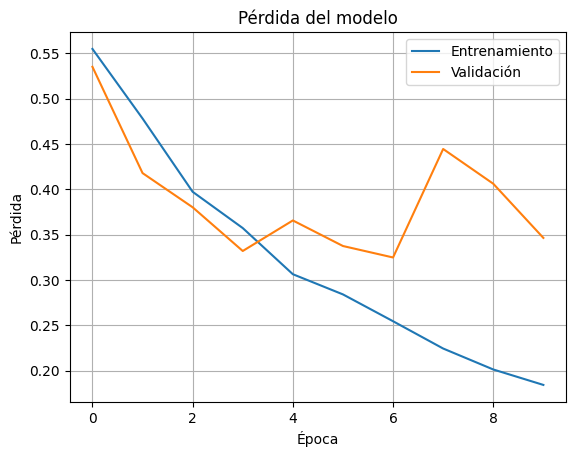

In [13]:
import matplotlib.pyplot as plt

# Precisión
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid()
plt.show()

# Pérdida
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid()
plt.show()

# **Gráficos comparativos**

Se visualizarán dos gráficos por modelo, donde se compararán la precisión y la pérdida del modelo entre el entrenamiento y la validación.

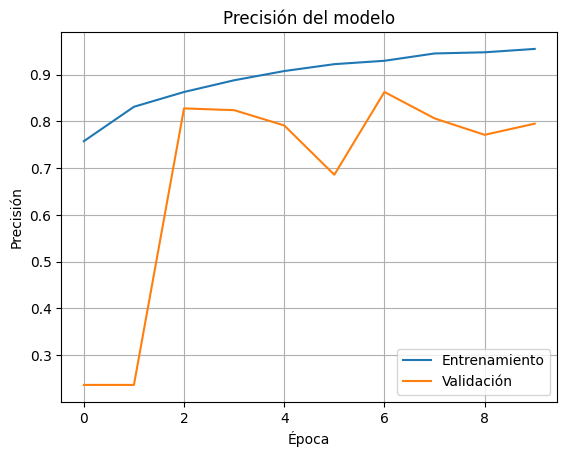

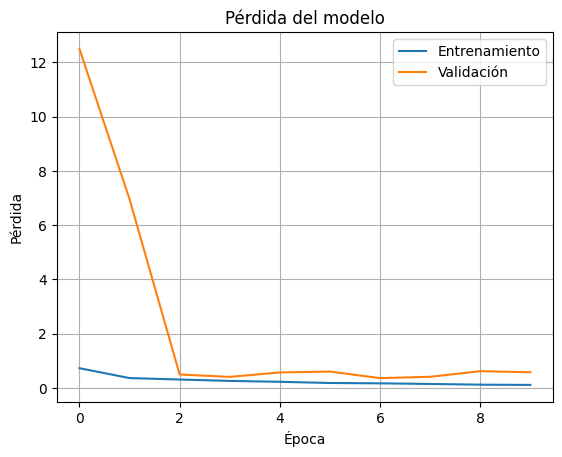

In [29]:
# Precisión
plt.plot(history2.history['accuracy'], label='Entrenamiento')
plt.plot(history2.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid()
plt.show()

# Pérdida
plt.plot(history2.history['loss'], label='Entrenamiento')
plt.plot(history2.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid()
plt.show()

In [14]:
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Pérdida en validación: {val_loss:.4f}")
print(f"Precisión en validación: {val_accuracy:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8785 - loss: 0.3355
Pérdida en validación: 0.3464
Precisión en validación: 0.8631


In [30]:
val_loss, val_accuracy = model_2.evaluate(val_generator)
print(f"Pérdida en validación: {val_loss:.4f}")
print(f"Precisión en validación: {val_accuracy:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.8033 - loss: 0.5071
Pérdida en validación: 0.5796
Precisión en validación: 0.7952


# **Predicción**

Procedamos a mostrar las predicciones hechas con los datos de validación y además evaluaremos la predicción del modelo con una imágen externa al dataset.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


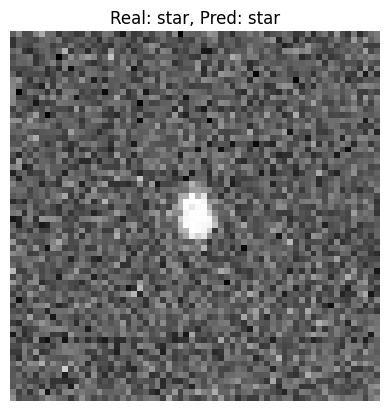

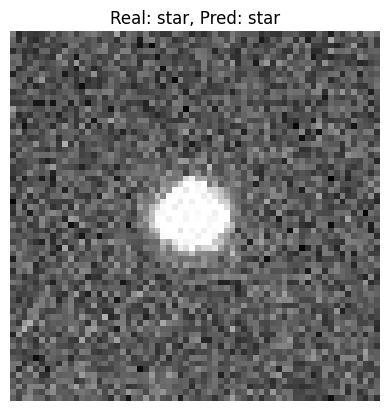

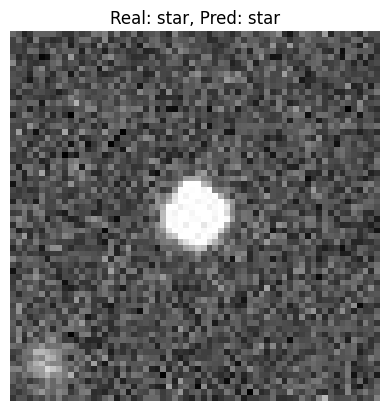

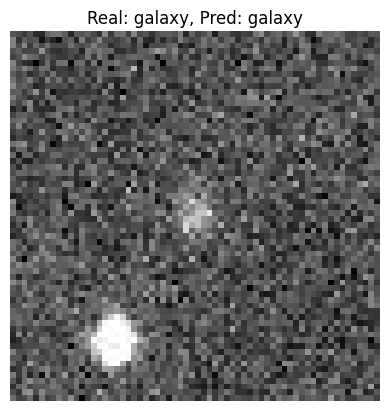

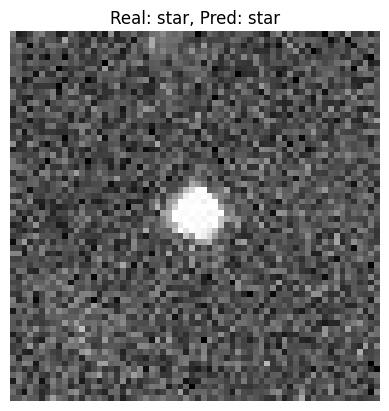

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Obtener un batch de imágenes desde el val_generator
images, labels = next(val_generator)

# Predecir con el modelo
predictions = model.predict(images)

# Mostrar las primeras 5 predicciones
class_names = list(val_generator.class_indices.keys())  # ['galaxy', 'star']

for i in range(5):
    plt.imshow(images[i])
    plt.title(f"Real: {class_names[np.argmax(labels[i])]}, Pred: {class_names[np.argmax(predictions[i])]}")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Predicción: galaxy con confianza 0.98


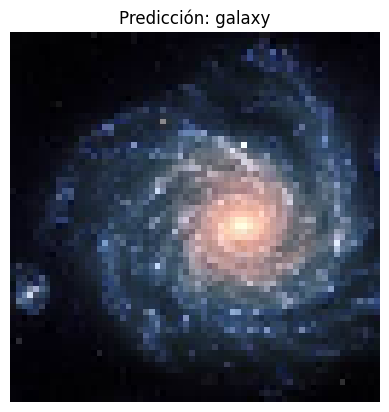

In [31]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Ruta a tu imagen externa
img_path = '/images.jpg'  # Cambia esto por la ruta real

# Cargar imagen y cambiar tamaño a 64x64 (como entrenaste)
img = image.load_img(img_path, target_size=(64, 64))

# Convertir a array numpy
img_array = image.img_to_array(img)

# Normalizar igual que en entrenamiento
img_array = img_array / 255.0

# Añadir dimensión batch (1, 64, 64, 3)
img_array = np.expand_dims(img_array, axis=0)

# Predecir
pred = model.predict(img_array)

# Obtener nombres de clases
class_names = list(train_generator.class_indices.keys())

# Mostrar resultados
predicted_class = class_names[np.argmax(pred[0])]
confidence = np.max(pred[0])

print(f"Predicción: {predicted_class} con confianza {confidence:.2f}")

# Mostrar imagen
plt.imshow(img)
plt.title(f"Predicción: {predicted_class}")
plt.axis('off')
plt.show()

# **Matriz de confusión**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


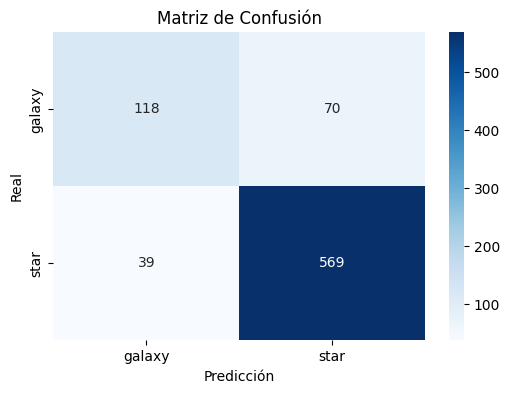

              precision    recall  f1-score   support

      galaxy       0.75      0.63      0.68       188
        star       0.89      0.94      0.91       608

    accuracy                           0.86       796
   macro avg       0.82      0.78      0.80       796
weighted avg       0.86      0.86      0.86       796



In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Obtener todas las etiquetas reales y predichas del set de validación
y_true = []
y_pred = []

for i in range(len(val_generator)):
    images, labels = val_generator[i]
    preds = model.predict(images)

    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Calcular la matriz
cm = confusion_matrix(y_true, y_pred)
class_names = list(val_generator.class_indices.keys())

# Visualizarla
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

# Reporte detallado
print(classification_report(y_true, y_pred, target_names=class_names))